# INM706 Coursework
## Disease Prognosis Prediction using Longitudinal Electronic Health Records and Gated Recurrent Units
### Aaron Mir (Student Number: 160001207)

MIMIC-III is a large, freely-available database comprising deidentified health-related data associated with over 40,000 patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. The MIMIC-III Clinical Database is available on PhysioNet (doi: 10.13026/C2XW26). Though deidentified, MIMIC-III contains detailed information regarding the care of real patients, and as such requires credentialing before access. 

Since each unique hospital visit for a patient is assigned a unique HADM_ID, the ADMISSIONS table can be considered as a definition table for HADM_ID.
Each row of this table contains a unique HADM_ID, which represents a single patient’s admission to the hospital. HADM_ID ranges from 1000000 - 1999999. It is possible for this table to have duplicate SUBJECT_ID, indicating that a single patient had multiple admissions to the hospital. The ADMISSIONS table can be linked to the PATIENTS table using SUBJECT_ID.
https://mimic.physionet.org/mimictables/admissions/ - info about admissions table

In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from datetime import datetime
import pickle
import torch 
# import torch.nn as nn
# from torch.autograd import Variable
# import torch.nn.functional as F
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
#np.set_printoptions(threshold=sys.maxsize)

## Exploratory Analysis of Data
### Admissions Table

In [2]:
admission_data = pd.read_csv('data\\ADMISSIONS.csv')

In [3]:
admission_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


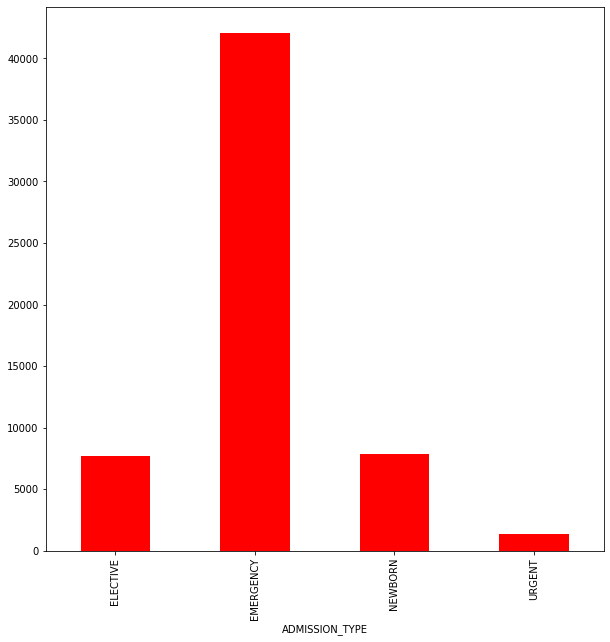

In [4]:
fig = plt.figure(figsize=(10,10))
admission_data.groupby(['ADMISSION_TYPE']).size().plot.bar(color = 'red');

In [5]:
admission_data.ADMITTIME = pd.to_datetime(admission_data.ADMITTIME, format = '%Y-%m-%d %H:%M:%S')
admission_data.DISCHTIME = pd.to_datetime(admission_data.DISCHTIME, format = '%Y-%m-%d %H:%M:%S')
admission_data.DEATHTIME = pd.to_datetime(admission_data.DEATHTIME, format = '%Y-%m-%d %H:%M:%S')

In [3]:
admission_data = admission_data.sort_values(['SUBJECT_ID','ADMITTIME'])
admission_data = admission_data.reset_index(drop = True)

In [4]:
admission_data.loc[admission_data.SUBJECT_ID  == 801, ['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE
987,801,2197-06-19 19:47:00,EMERGENCY
988,801,2197-08-09 21:00:00,EMERGENCY
989,801,2198-07-09 23:22:00,EMERGENCY


In [5]:
admission_data['NEXT_ADMITTIME'] = admission_data.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
admission_data['NEXT_ADMISSION_TYPE'] = admission_data.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [6]:
admission_data.loc[admission_data.SUBJECT_ID == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
987,801,2197-06-19 19:47:00,EMERGENCY,2197-08-09 21:00:00,EMERGENCY
988,801,2197-08-09 21:00:00,EMERGENCY,2198-07-09 23:22:00,EMERGENCY
989,801,2198-07-09 23:22:00,EMERGENCY,NaN,NaN


In [7]:
rows = admission_data.NEXT_ADMISSION_TYPE == 'ELECTIVE'
admission_data.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
admission_data.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [8]:
admission_data.loc[admission_data.SUBJECT_ID == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
987,801,2197-06-19 19:47:00,EMERGENCY,2197-08-09 21:00:00,EMERGENCY
988,801,2197-08-09 21:00:00,EMERGENCY,2198-07-09 23:22:00,EMERGENCY
989,801,2198-07-09 23:22:00,EMERGENCY,NaN,NaN


In [9]:
admission_data = admission_data.sort_values(['SUBJECT_ID','ADMITTIME'])

In [10]:
admission_data.loc[admission_data.SUBJECT_ID == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
987,801,2197-06-19 19:47:00,EMERGENCY,2197-08-09 21:00:00,EMERGENCY
988,801,2197-08-09 21:00:00,EMERGENCY,2198-07-09 23:22:00,EMERGENCY
989,801,2198-07-09 23:22:00,EMERGENCY,NaN,NaN


In [11]:
admission_data[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = admission_data.groupby(['SUBJECT_ID'])\
[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [12]:
admission_data.loc[admission_data.SUBJECT_ID == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
987,801,2197-06-19 19:47:00,EMERGENCY,2197-08-09 21:00:00,EMERGENCY
988,801,2197-08-09 21:00:00,EMERGENCY,2198-07-09 23:22:00,EMERGENCY
989,801,2198-07-09 23:22:00,EMERGENCY,NaN,NaN


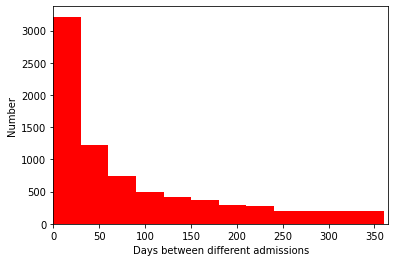

In [19]:
fig = plt.figure() 
admission_data['DAYS_NEXT_ADMIT'] = (admission_data.NEXT_ADMITTIME - admission_data.DISCHTIME).dt.total_seconds()/(24*60*60)
plt.hist(admission_data.loc[~admission_data.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins = range(0,365,30), color = 'red')
plt.xlim([0,365])
plt.xlabel('Days between different admissions')
plt.ylabel('Number')
plt.show()

### Notes Table

In [13]:
notes_data = pd.read_csv('data\\NOTEEVENTS.csv')

C:\Python38\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [21]:
notes_data.head() 

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [20]:
print('Number of notes:',len(notes_data))

Number of notes: 2083180


In [21]:
notes_data.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

<AxesSubplot:xlabel='CATEGORY'>

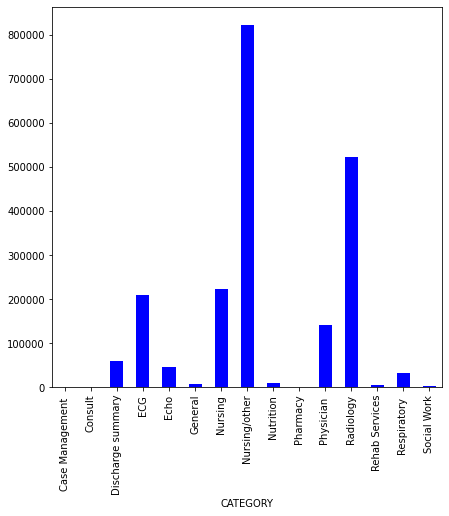

In [26]:
fig = plt.figure(figsize=(7, 7)) 
notes_data.groupby(['CATEGORY']).size().plot.bar(color = 'blue')

### Diagnosis Code Table

In [14]:
diagnosis_code_data = pd.read_csv('data\\DIAGNOSES_ICD.csv')

In [28]:
diagnosis_code_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [29]:
diagnosis_code_data

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254
...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280
651043,639799,97503,188195,3.0,V5869
651044,639800,97503,188195,4.0,V1279
651045,639801,97503,188195,5.0,5275


### Diagnosis Table

In [15]:
diagnosis_data = pd.read_csv('data\\D_ICD_DIAGNOSES.csv')

In [25]:
diagnosis_data.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


### Patients Table

In [26]:
patient_data = pd.read_csv('data\\PATIENTS.csv')

In [27]:
patient_data.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [28]:
print(f"Total Patients: {len(patient_data)}")
print(f"Number of Males: {len(patient_data[patient_data['GENDER'] == 'M'])}")
print(f"Number of Females: {len(patient_data[patient_data['GENDER'] == 'F'])}")

Total Patients: 46520
Number of Males: 26121
Number of Females: 20399


C:\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


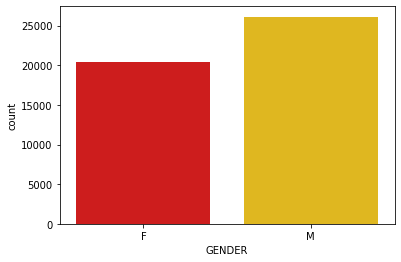

In [29]:
sns.countplot(patient_data['GENDER'], palette="hot")
plt.show()

## Data pre-processing#

Checklist

    1. Extract hadm_id, subject_id_ admittime, dischtime, icd9_code, description_of_code (long_title) and create new table
    2. Map the subject_id with the hadm_id and the admittime to match a patient to specific visits
    3. Map the hadm_id to each icd9_code assigned during the visit
    4. Add each code assigned to the patient directing into the dictionary with the patient-admission id mapping and the visit date mapping . Which allows us to have a list of list of icd9_code's that each patient recieved during each visit

ADMISSIONS: Every unique hospitalisation for each patient in the database (defines HADM_ID)

DIAGNOSES_ICD: Hospital assigned diagnoses, coded using the International Statistical Classification of Diseases and Related Health Problems (ICD) system

D_ICD_DIAGNOSES: Dictionary of International Statistical Classification of Diseases and Related Health Problems (ICD) codes relating to diagnoses

Each HADM_ID corresponds to a single SUBJECT_ID. A single SUBJECT_ID can correspond to multiple HADM_ID (multiple hospitalizations of the same patient), and multiple ICUSTAY_ID (multiple ICU stays either within the same hospitalization, or across multiple hospitalizations, or both).

In [16]:
admission_data

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaN,NaN
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,NaN,NaN
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,NaN,NaN
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaN,NaN
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58972,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,...,JEWISH,MARRIED,WHITE,2181-01-26 23:35:00,2181-01-27 04:18:00,FEVER,0,1,NaN,NaN
58972,58973,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,DIVERTICULITIS/SDA,0,1,NaN,NaN
58973,58974,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,...,CATHOLIC,WIDOWED,WHITE,2144-07-25 13:40:00,2144-07-25 18:50:00,RETROPERITONEAL HEMORRHAGE,0,1,NaN,NaN
58974,58975,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,...,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,NaN,NaN


In [17]:
diagnosis_code_data

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254
...,...,...,...,...,...
651042,639798,97503,188195,2.0,20280
651043,639799,97503,188195,3.0,V5869
651044,639800,97503,188195,4.0,V1279
651045,639801,97503,188195,5.0,5275


In [18]:
admission_data[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00
...,...,...,...,...
58971,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00
58972,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00
58973,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00
58974,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00


In [49]:
#reordering admission data so we can put into a suitable format for adding other columns from other tables
admission_data[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']].sort_values(['SUBJECT_ID','HADM_ID']) # ordered based on subject id and hadm_id

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00
...,...,...,...,...
58971,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00
58972,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00
58973,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00
58974,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00


In [107]:
# changing the table name to data since we will add columns from other tables to this one
data = admission_data[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']].sort_values(['SUBJECT_ID','HADM_ID'])
data.to_csv('data/ADMISSIONS_shrink.csv')

In [145]:
# create two dictionaries: one that maps each patient with their specific HADM_ID
#                          another that maps each HADM_ID with the date and time of the admission
subject_hadm_map = {}
hadm_date_map = {}
for subject_id in data.SUBJECT_ID:
    subject_hadm_map[str(subject_id)] = list(map(str, list(data[data['SUBJECT_ID'] == subject_id]['HADM_ID'].values)))
for hadm_id in data.HADM_ID:
    hadm_date_map[str(hadm_id)] = [datetime.strptime(data[data['HADM_ID'] == hadm_id]['ADMITTIME'].values[0], '%Y-%m-%d %H:%M:%S')]

In [148]:
subject_hadm_map['17']

['161087', '194023']

In [149]:
print(hadm_date_map['161087'])
print(hadm_date_map['194023'])

[datetime.datetime(2135, 5, 9, 14, 11)]
[datetime.datetime(2134, 12, 27, 7, 15)]


In [54]:
# reordering diagnosis code data to create the necessary future mappings
diagnosis_code_data[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].sort_values(['SUBJECT_ID','HADM_ID']) # ordered based on subject id and hadm_id

,SUBJECT_ID,HADM_ID,ICD9_CODE
608,2,163353,V3001
609,2,163353,V053
610,2,163353,V290
611,3,145834,0389
612,3,145834,78559
...,...,...,...
648478,99999,113369,75612
648479,99999,113369,7861
648480,99999,113369,4019
648481,99999,113369,25000


In [20]:
diagnosis_code_data = diagnosis_code_data[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].sort_values(['SUBJECT_ID','HADM_ID'])  # putting diagnosis code data into the above format

In [120]:
# create a dictionary that maps each HADM_ID with the specific ICD9 diagnosis codes given during the visit
hadm_icd9_map = {}          
for hadm_id in data.HADM_ID:
    hadm_icd9_map[str(hadm_id)] = list(diagnosis_code_data[diagnosis_code_data['HADM_ID'] == hadm_id]['ICD9_CODE'].values)

In [150]:
print(hadm_icd9_map['161087'])
print(hadm_icd9_map['194023'])

['4239', '5119', '78551', '4589', '311', '7220', '71946', '2724']
['7455', '45829', 'V1259', '2724']


In [151]:
# create a dictionary mapping subject_id to their admittime for each hadm_id and the diagnoses for that admission
subject_admittime_icd9 = {}
for subject_id, admit_time in subject_hadm_map.items():
    ordered_map = ([(hadm_date_map[admittime], hadm_icd9_map[admittime]) for admittime in admittime])
    subject_admittime_icd9[subject_id] = ordered_map

In [153]:
subject_admittime_icd9['17']

[([datetime.datetime(2135, 5, 9, 14, 11)],
  ['4239', '5119', '78551', '4589', '311', '7220', '71946', '2724']),
 ([datetime.datetime(2134, 12, 27, 7, 15)],
  ['7455', '45829', 'V1259', '2724'])]

In [154]:
# extract a list of subject_IDs, admittimes and icd9_codes for encoding
subject_IDs = [subject_id for subject_id, admittime in subject_admittime_icd9.items()]
admit_times_list = [[visit[0][0] for visit in admittime] for subject_id, admittime in subject_admittime_icd9.items()]
icd9_codes_list = [[visit[1] for visit in admittime] for subject_id, admittime in subject_admittime_icd9.items()]

In [156]:
subject_IDs[:5]

['2', '3', '4', '5', '6']

In [157]:
admit_times_list[:5]

[[datetime.datetime(2138, 7, 17, 19, 4)],
 [datetime.datetime(2101, 10, 20, 19, 8)],
 [datetime.datetime(2191, 3, 16, 0, 28)],
 [datetime.datetime(2103, 2, 2, 4, 31)],
 [datetime.datetime(2175, 5, 30, 7, 15)]]

In [158]:
icd9_codes_list[:5]

[[['V3001', 'V053', 'V290']],
 [['0389', '78559', '5849', '4275', '41071', '4280', '6826', '4254', '2639']],
 [['042', '1363', '7994', '2763', '7907', '5715', '04111', 'V090', 'E9317']],
 [['V3000', 'V053', 'V290']],
 [['40391', '4440', '9972', '2766', '2767', '2859', '2753', 'V1582']]]

In [160]:
# create a dictionary of the diagnosis codes assigned at each visit for each unique subject_id by encoding diagnosis codes into integers
icd9_code_dict = {}
encoded_icd9s = []
for subject in icd9_codes_list:
    encoded_subject_icd9s = []
    for admission in subject:
        encoded_admission = []
        for code in admission:
            if code in icd9_code_dict:
                encoded_admission.append(icd9_code_dict[code])
            else:
                icd9_code_dict[code] = len(icd9_code_dict)
                encoded_admission.append(icd9_code_dict[code])
        encoded_subject_icd9s.append(encoded_admission)
    encoded_icd9s.append(encoded_subject_icd9s)

In [163]:
icd9_code_dict['V053']

1

In [165]:
encoded_icd9s[0]

[[0, 1, 2]]

In [167]:
# pickle the lists for quick loading in future
pickle.dump(subject_IDs, open('data'+'.subject_IDs', 'wb'), -1)
pickle.dump(admit_times_list, open('data'+'.admit_times', 'wb'), -1)
pickle.dump(encoded_icd9s, open('data'+'.encoded_icd9s', 'wb'), -1)  
pickle.dump(icd9_code_dict, open('data'+'.icd9_code_dict', 'wb'), -1)

## Preparation for data, labels

In [ ]:
# 6322 max max
#:35000 split

In [1]:
import pandas as pd
import numpy as np
import random
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from datetime import datetime
import pickle
import torch 
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
#np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(edgeitems=10)

In [2]:
# loading the data and reducing its size for 
encoded_icd9_data = np.array(pickle.load(open('data/data.encoded_icd9s','rb')), dtype=object)
encoded_icd9_data = encoded_icd9_data[:35000]
encoded_icd9_data = [sorted(icd9_data) for icd9_data in encoded_icd9_data]

In [25]:
encoded_icd9_data[0] # 1 admission

[[0, 1, 2]]

In [4]:
len(encoded_icd9_data[17]) # 2 admissions written similar to above

2

In [5]:
for i in range(10):    
    lengths = np.array([len(codes) for codes in encoded_icd9_data]) -1      # subtract 1 from the length which means that the last visit in each patient's record will be removed 
    maxo = np.max(lengths)
    where = np.where(lengths == maxo)
    encoded_icd9_data.pop(where[0][0])                  # removing the 10 patients with the largest admissions to help with memory constraints

In [3]:
max(max(max(encoded_icd9_data)))

6322

In [4]:
lengths = np.array([len(codes) for codes in encoded_icd9_data]) -1      # subtract 1 from the length which means that the last visit in each patient's record will be removed 
maxo = np.max(lengths)
where = np.where(lengths == maxo)
print(maxo)

41


In [7]:
# order encoded_icd9_data with the longest sequence coming first - number of tokens = np.max(np.max(encoded_icd9_data)) = 5421

In [3]:
# with padding, the last visit in each patient's record is removed because both the admission and the label sizes must match  
# next, the data is ordered from the patient that has the most admissions to the least. Each admission will be considered a token. 
# then for each patient that has a lower amount of admissions than the highest, their admissions are padded with zeros.
# finally, we multi-one hot encode the data which puts out data in the form (sequence length x batch size x vocab) 
def padding(data, labels, vocab, numClasses):
    lengths = np.array([len(admissions) for admissions in data]) -1      # subtract 1 from the length which means that the last visit in each patient's record will be removed 
    maxlen = np.max(lengths)
    num_samples = len(data)
    print(lengths)
    print(maxlen)
    print(num_samples)
    x = torch.zeros(maxlen, num_samples, vocab)                            # maxlen = number of visits, n_samples = samples
    y = torch.zeros(maxlen, num_samples, numClasses)
    mask = torch.zeros(maxlen, num_samples)

    for idx, (admissions, label) in enumerate(zip(data, labels)):
        for x_true, section in zip(x[:, idx, :], admissions[:-1]): 
            xvec[section] = 1.
        for y_true, section in zip(y[:, idx, :], label[1:]:    # labels are the next visit
            yvec[section] = 1. 

        mask[:lengths[idx], idx] = 1.

    lengths = torch.LongTensor(lengths)
    print(x.size())
    print(y.size())
    print(mask.size())
    print(lengths.size())
    return x, y, mask, lengths

In [4]:
x, y, mask, lengths = padding(encoded_icd9_data, encoded_icd9_data, 6322, 6322) # 6322 tokens in the vocabulary - uses about 27gb RAM

[0 0 0 ... 0 0 0]
41
35000


IndexError: index 6322 is out of bounds for dimension 0 with size 6322

In [6]:
torch.max(x)

tensor(1.)

In [7]:
torch.max(y)

tensor(1.)

In [ ]:
# np.save('data/data.npy', x.numpy())
# np.load('data/labels.npy')
# np.load('data/mask.npy')
# np.load('data/lengths.npy')

In [2]:
# x = torch.tensor(np.load('data/data.npy'), dtype=torch.float)
# y = torch.tensor(np.load('data/labels.npy'), dtype=torch.float)
# mask = torch.tensor(np.load('data/mask.npy'), dtype=torch.float)
# lengths = torch.tensor(np.load('data/lengths.npy'), dtype=torch.long)

In [5]:
print(x.size()) # in the form 
print(y.size())
print(mask.size())
print(lengths.size())

torch.Size([41, 35000, 6322])
torch.Size([41, 35000, 6322])
torch.Size([41, 35000])
torch.Size([35000])


In [8]:
np.where(x[:,1,:]==1)

(array([], dtype=int64), array([], dtype=int64))

In [19]:
np.where(y[:,:,:]==1)

(array([ 0,  0,  0, ..., 15, 15, 15], dtype=int64),
 array([   13,    13,    13, ..., 22365, 22365, 22365], dtype=int64),
 array([  60,   61,   62, ..., 2142, 3531, 5378], dtype=int64))

In [23]:
x[0, 13, 53] # batch size 1 showing the padded 6322 tokens at sequence length 16

tensor(1.)

In [4]:
torch.max(x)

tensor(1.)

In [5]:
torch.max(y)

tensor(1.)

In [10]:
x[0, 0, :]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [8]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 10
NUM_EPOCHS = 1
NUM_WORKERS = 0

## Model

## Training

### Ignore

In [ ]:
idx_remove = np.random.randint(0, np.size(encoded_icd9_data)-1, size=13520)        
encoded_icd9_data = np.delete(encoded_icd9_data, idx_remove)

In [ ]:
# adding IDD9 codes and info to admission data
df1['columename']= df2['existing_colume_name']

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # ordered based on subject id and admit_time but is currently based on subject id and HADM_ID
    print(admission_data.sort_values(['SUBJECT_ID', 'ADMITTIME']))